# 1. From Posts(=submissions) to Networks

The goal of this section is to break-down a dataframe full of submissions, into a network. We will then visualize this network.
The overall steps are:
- Load the dataframe.
- Filter rows that contain interactions, i.e., commenting events.
- Generating an edgelist, then use it to generate a network object.
- Visualize network

# Install dependencies and import modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Tutorial_2'

/content/drive/MyDrive/Tutorial_2


In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import nltk

import datetime

# Read dataframe
We will use three files:  
(1) datascience-new-comment.csv: contains information on comments  
(2) datascience-new-submission.csv: contains information on submissions  
(3) datascience-user-data.csv: contains information on users

In [4]:
comments_df = pd.read_csv("./datascience-new-comment.csv", index_col=0)
comments_df.columns

Index(['author', 'body', 'body_html', 'created_utc', 'distinguished', 'edited',
       'id', 'is_submitter', 'link_id', 'parent_id', 'permalink', 'replies',
       'saved', 'score', 'stickied', 'submission', 'subreddit',
       'subreddit_id'],
      dtype='object')

In [5]:
# 'created_utc' column contains Unix timestamp.
# This format tells us how many seconds have past since 1970-01-01 00:00:00
# Quite impressive (and actually practical), but not straightforward for us humans.
# Let's transforme those into YYYY-mm-dd hh:mm:ss format and save them in another column.

comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,ghostofkilgore,I'm European and have worked with a few DS fro...,"<div class=""md""><p>I&#39;m European and have w...",1.726055e+09,NaN,False,lml83ai,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,14,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 11:39:31
1,aimendezl,"Hey there, I'm Chilean living in The Netherlan...","<div class=""md""><p>Hey there, I&#39;m Chilean ...",1.726042e+09,NaN,1726042073.0,lmknx5v,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,3,False,36,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 08:02:29
2,Silent-Sunset,From what I had experienced during a year stud...,"<div class=""md""><p>From what I had experienced...",1.726049e+09,NaN,False,lmkxi3w,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,7,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 09:58:04
3,aintwhatyoudo,"Just saying.\n\n""Latam"" in Polish means ""I'm f...","<div class=""md""><p>Just saying.</p>\n\n<p>&quo...",1.726059e+09,NaN,False,lmliqu6,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,1,False,4,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 12:57:23
4,MattDamonsTaco,Had a Peruvian on my team at a FAANG who was t...,"<div class=""md""><p>Had a Peruvian on my team a...",1.726061e+09,NaN,False,lmlo15v,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,3,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 13:30:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Educational_Can_4652,When they call to reject is the best time to a...,"<div class=""md""><p>When they call to reject is...",1.726167e+09,NaN,False,lmt3g8s,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:46:07
296,JosephMamalia,Its always appropriate to ask and I just inclu...,"<div class=""md""><p>Its always appropriate to a...",1.726167e+09,NaN,False,lmt47yj,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:50:15
297,AlgoRhythmCO,You can ask but you won’t get a response. Liab...,"<div class=""md""><p>You can ask but you won’t g...",1.726167e+09,NaN,False,lmt5imt,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:57:19
298,LyleLanleysMonorail,It's not a liability. It's something that redd...,"<div class=""md""><p>It&#39;s not a liability. I...",1.726168e+09,NaN,False,lmt7rpo,False,t3_1ff9usy,t1_lmt74tb,/r/datascience/comments/1ff9usy/is_it_ever_app...,1,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 19:09:31


# Short-hand Pandas Filters


#### First, we filter comments that are under other comments, and are made at a specific date.  
In this case, 'parent_id' attribute starts with t1.

In [6]:
## | is short-hand for OR ; & is short-hand for AND
today = datetime.datetime(2024, 9, 11)

comments_to_comments_df = comments_df[(comments_df.parent_id.str.startswith('t1')) & (comments_df.created_utc_datetime >= today)]
comments_to_comments_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
16,SurveyNo2684,Damn right. This is true.,"<div class=""md""><p>Damn right. This is true.</...",1.726053e+09,NaN,False,lml4nl2,False,t3_1fe3ybi,t1_lmknx5v,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,1,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 11:10:28
17,gomezalp,"Valuable answer bro, I agree with your point o...","<div class=""md""><p>Valuable answer bro, I agre...",1.726092e+09,NaN,False,lmo9hj8,True,t3_1fe3ybi,t1_lmknx5v,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,1,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 21:56:17
18,danielfm123,"Chilean moving to Europe too, thanks for the i...","<div class=""md""><p>Chilean moving to Europe to...",1.726101e+09,NaN,False,lmoytye,False,t3_1fe3ybi,t1_lmknx5v,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,1,False,1fe3ybi,datascience,t5_2sptq,2024-09-12 00:33:56
19,edjuaro,Which is funny since there is an airline calle...,"<div class=""md""><p>Which is funny since there ...",1.726066e+09,NaN,False,lmm0wt6,False,t3_1fe3ybi,t1_lmliqu6,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,6,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 14:45:05
20,Pristine-Item680,My wife is Colombian and she breaks it down pr...,"<div class=""md""><p>My wife is Colombian and sh...",1.726074e+09,NaN,False,lmmqqp3,False,t3_1fe3ybi,t1_lmm24u6,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,5,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 17:02:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,manueldoedmotta,"If the models are for different clients, I thi...","<div class=""md""><p>If the models are for diffe...",1.726143e+09,NaN,False,lmr4ecz,False,t3_1fehm3k,t1_lmqztv2,/r/datascience/comments/1fehm3k/is_it_ok_to_ta...,0,False,2,False,1fehm3k,datascience,t5_2sptq,2024-09-12 12:04:53
287,gomezalp,By 'run' I meant be able to load and execute a...,"<div class=""md""><p>By &#39;run&#39; I meant be...",1.726122e+09,NaN,False,lmq8dd4,True,t3_1fetk7f,t1_lmq27wa,/r/datascience/comments/1fetk7f/whats_the_limi...,1,False,4,False,1fetk7f,datascience,t5_2sptq,2024-09-12 06:27:35
288,laughingwalls,Ive read that chat gpt2 can be run on a pc.,"<div class=""md""><p>Ive read that chat gpt2 can...",1.726161e+09,NaN,False,lmsjt01,False,t3_1fetk7f,t1_lmq8dd4,/r/datascience/comments/1fetk7f/whats_the_limi...,0,False,1,False,1fetk7f,datascience,t5_2sptq,2024-09-12 17:02:49
298,LyleLanleysMonorail,It's not a liability. It's something that redd...,"<div class=""md""><p>It&#39;s not a liability. I...",1.726168e+09,NaN,False,lmt7rpo,False,t3_1ff9usy,t1_lmt74tb,/r/datascience/comments/1ff9usy/is_it_ever_app...,1,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 19:09:31


#### Next, we filter comments that are directly below submissions, and are made at a specific date (2023-08-22).
In this case, 'parent_id' attribute starts with t3.

In [7]:
## | is short-hand for OR ; & is short-hand for AND
comments_to_submissions_df = comments_df[(comments_df.parent_id.str.startswith('t3') & (comments_df.created_utc_datetime >= today) & (comments_df.is_submitter == False))]
comments_to_submissions_df

,author,body,body_html,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,replies,saved,score,stickied,submission,subreddit,subreddit_id,created_utc_datetime
0,ghostofkilgore,I'm European and have worked with a few DS fro...,"<div class=""md""><p>I&#39;m European and have w...",1.726055e+09,NaN,False,lml83ai,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,14,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 11:39:31
1,aimendezl,"Hey there, I'm Chilean living in The Netherlan...","<div class=""md""><p>Hey there, I&#39;m Chilean ...",1.726042e+09,NaN,1726042073.0,lmknx5v,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,3,False,36,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 08:02:29
2,Silent-Sunset,From what I had experienced during a year stud...,"<div class=""md""><p>From what I had experienced...",1.726049e+09,NaN,False,lmkxi3w,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,7,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 09:58:04
3,aintwhatyoudo,"Just saying.\n\n""Latam"" in Polish means ""I'm f...","<div class=""md""><p>Just saying.</p>\n\n<p>&quo...",1.726059e+09,NaN,False,lmliqu6,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,1,False,4,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 12:57:23
4,MattDamonsTaco,Had a Peruvian on my team at a FAANG who was t...,"<div class=""md""><p>Had a Peruvian on my team a...",1.726061e+09,NaN,False,lmlo15v,False,t3_1fe3ybi,t3_1fe3ybi,/r/datascience/comments/1fe3ybi/are_there_any_...,0,False,3,False,1fe3ybi,datascience,t5_2sptq,2024-09-11 13:30:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,RB_7,"Always fine to ask, but don't expect a response.","<div class=""md""><p>Always fine to ask, but don...",1.726167e+09,NaN,False,lmt5itu,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:57:21
294,DubGrips,Every tech company I have worked for has a str...,"<div class=""md""><p>Every tech company I have w...",1.726168e+09,NaN,False,lmt7apj,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 19:06:56
295,Educational_Can_4652,When they call to reject is the best time to a...,"<div class=""md""><p>When they call to reject is...",1.726167e+09,NaN,False,lmt3g8s,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:46:07
296,JosephMamalia,Its always appropriate to ask and I just inclu...,"<div class=""md""><p>Its always appropriate to a...",1.726167e+09,NaN,False,lmt47yj,False,t3_1ff9usy,t3_1ff9usy,/r/datascience/comments/1ff9usy/is_it_ever_app...,0,False,1,False,1ff9usy,datascience,t5_2sptq,2024-09-12 18:50:15


### We want to make edgelists.  
When comments are made below comments, they create a link in this case.  
Thus, 'source' is a comment under 'target' comment.

In [8]:
submission_df = pd.read_csv('./datascience-new-submission.csv', index_col=0)

In [9]:
# This dataframe shows who made 'source' comments, and the 'target' comments' ids

df1 = comments_to_comments_df[['author', 'parent_id', 'body']].copy()
df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']
df1

,comment_to_comment_author,comment_id,comment_body
16,SurveyNo2684,lmknx5v,Damn right. This is true.
17,gomezalp,lmknx5v,"Valuable answer bro, I agree with your point o..."
18,danielfm123,lmknx5v,"Chilean moving to Europe too, thanks for the i..."
19,edjuaro,lmliqu6,Which is funny since there is an airline calle...
20,Pristine-Item680,lmm24u6,My wife is Colombian and she breaks it down pr...
...,...,...,...
282,manueldoedmotta,lmqztv2,"If the models are for different clients, I thi..."
287,gomezalp,lmq27wa,By 'run' I meant be able to load and execute a...
288,laughingwalls,lmq8dd4,Ive read that chat gpt2 can be run on a pc.
298,LyleLanleysMonorail,lmt74tb,It's not a liability. It's something that redd...


In [10]:
# This dataframe shows who made 'target' comments, and the 'target' comments' ids

df2 = comments_to_comments_df[['author', 'id']]
df2.columns = ['comment_author', 'comment_id']
df2

,comment_author,comment_id
16,SurveyNo2684,lml4nl2
17,gomezalp,lmo9hj8
18,danielfm123,lmoytye
19,edjuaro,lmm0wt6
20,Pristine-Item680,lmmqqp3
...,...,...
282,manueldoedmotta,lmr4ecz
287,gomezalp,lmq8dd4
288,laughingwalls,lmsjt01
298,LyleLanleysMonorail,lmt7rpo


In [11]:
# merging two dataframe by inner join makes edgelists

df = df1.merge(df2, how='inner', on='comment_id')
df

,comment_to_comment_author,comment_id,comment_body,comment_author
0,pm_me_your_smth,lmkh6z5,I agree with the thought that there are situat...,Gold-Artichoke-9288
1,No-Hat446,lmkh6z5,grow up,Gold-Artichoke-9288
2,sandith752,lmkh6z5,It's quite literally the future whether you li...,Gold-Artichoke-9288
3,juliano1096,lmkhrx3,Only docker already takes a lot of resources. ...,Gold-Artichoke-9288
4,Accomplished-Wave356,lml5066,Teachers better be aware.,sandith752
...,...,...,...,...
122,manueldoedmotta,lmqv9mf,"Ok, so the average MAPE of all models don’t lo...",venkarafa
123,venkarafa,lmqwvwr,"""A suggestion is create a new metric like “Ove...",manueldoedmotta
124,manueldoedmotta,lmqztv2,"If the models are for different clients, I thi...",venkarafa
125,laughingwalls,lmq8dd4,Ive read that chat gpt2 can be run on a pc.,gomezalp


In [12]:
comments_network_df = df[['comment_to_comment_author', 'comment_author', 'comment_body']]
comments_network_df.columns = ['source', 'target', 'comment']
comments_network_df

,source,target,comment
0,pm_me_your_smth,Gold-Artichoke-9288,I agree with the thought that there are situat...
1,No-Hat446,Gold-Artichoke-9288,grow up
2,sandith752,Gold-Artichoke-9288,It's quite literally the future whether you li...
3,juliano1096,Gold-Artichoke-9288,Only docker already takes a lot of resources. ...
4,Accomplished-Wave356,sandith752,Teachers better be aware.
...,...,...,...
122,manueldoedmotta,venkarafa,"Ok, so the average MAPE of all models don’t lo..."
123,venkarafa,manueldoedmotta,"""A suggestion is create a new metric like “Ove..."
124,manueldoedmotta,venkarafa,"If the models are for different clients, I thi..."
125,laughingwalls,gomezalp,Ive read that chat gpt2 can be run on a pc.


Also, when comments are made below submissions(=posts), they create a link in this case.  
Thus, 'source' is a comment under a 'target' post.

In [13]:
df3 = comments_to_submissions_df[['author', 'body', 'link_id']].copy()
df3['link_id'] = df3['link_id'].str.split('_').str[-1]
df3.columns = ['comment_author', 'comment_body', 'submission_id']
df3

,comment_author,comment_body,submission_id
0,ghostofkilgore,I'm European and have worked with a few DS fro...,1fe3ybi
1,aimendezl,"Hey there, I'm Chilean living in The Netherlan...",1fe3ybi
2,Silent-Sunset,From what I had experienced during a year stud...,1fe3ybi
3,aintwhatyoudo,"Just saying.\n\n""Latam"" in Polish means ""I'm f...",1fe3ybi
4,MattDamonsTaco,Had a Peruvian on my team at a FAANG who was t...,1fe3ybi
...,...,...,...
293,RB_7,"Always fine to ask, but don't expect a response.",1ff9usy
294,DubGrips,Every tech company I have worked for has a str...,1ff9usy
295,Educational_Can_4652,When they call to reject is the best time to a...,1ff9usy
296,JosephMamalia,Its always appropriate to ask and I just inclu...,1ff9usy


In [14]:
df4 = submission_df[['author', 'id']]
df4.columns = ['submission_author', 'submission_id']
df4

,submission_author,submission_id
0,santiviquez,1ffa09p
1,jmhimara,1ff9usy
2,nobody_undefined,1feyx6h
3,gomezalp,1fetk7f
4,Waste_Necessary654,1fer01g
5,starktonny11,1feje1i
6,venkarafa,1fehm3k
7,ArticleLegal5612,1fecoyd
8,gomezalp,1fe3ybi
9,Gold-Artichoke-9288,1fdx805


In [15]:
df = df3.merge(df4, how='inner', on='submission_id')
df

,comment_author,comment_body,submission_id,submission_author
0,ghostofkilgore,I'm European and have worked with a few DS fro...,1fe3ybi,gomezalp
1,aimendezl,"Hey there, I'm Chilean living in The Netherlan...",1fe3ybi,gomezalp
2,Silent-Sunset,From what I had experienced during a year stud...,1fe3ybi,gomezalp
3,aintwhatyoudo,"Just saying.\n\n""Latam"" in Polish means ""I'm f...",1fe3ybi,gomezalp
4,MattDamonsTaco,Had a Peruvian on my team at a FAANG who was t...,1fe3ybi,gomezalp
...,...,...,...,...
110,RB_7,"Always fine to ask, but don't expect a response.",1ff9usy,jmhimara
111,DubGrips,Every tech company I have worked for has a str...,1ff9usy,jmhimara
112,Educational_Can_4652,When they call to reject is the best time to a...,1ff9usy,jmhimara
113,JosephMamalia,Its always appropriate to ask and I just inclu...,1ff9usy,jmhimara


In [16]:
sub_com_network_df = df[['comment_author', 'submission_author', 'comment_body']]
sub_com_network_df.columns = ['source', 'target', 'comment']
sub_com_network_df

,source,target,comment
0,ghostofkilgore,gomezalp,I'm European and have worked with a few DS fro...
1,aimendezl,gomezalp,"Hey there, I'm Chilean living in The Netherlan..."
2,Silent-Sunset,gomezalp,From what I had experienced during a year stud...
3,aintwhatyoudo,gomezalp,"Just saying.\n\n""Latam"" in Polish means ""I'm f..."
4,MattDamonsTaco,gomezalp,Had a Peruvian on my team at a FAANG who was t...
...,...,...,...
110,RB_7,jmhimara,"Always fine to ask, but don't expect a response."
111,DubGrips,jmhimara,Every tech company I have worked for has a str...
112,Educational_Can_4652,jmhimara,When they call to reject is the best time to a...
113,JosephMamalia,jmhimara,Its always appropriate to ask and I just inclu...


Now, we can concat both of edgelist dataframes (comment -> comment, comment -> submission) and finalize our edgelist dataframe.

In [17]:
network_df = pd.concat([sub_com_network_df, comments_network_df], axis=0).reset_index(drop=True)
network_df

,source,target,comment
0,ghostofkilgore,gomezalp,I'm European and have worked with a few DS fro...
1,aimendezl,gomezalp,"Hey there, I'm Chilean living in The Netherlan..."
2,Silent-Sunset,gomezalp,From what I had experienced during a year stud...
3,aintwhatyoudo,gomezalp,"Just saying.\n\n""Latam"" in Polish means ""I'm f..."
4,MattDamonsTaco,gomezalp,Had a Peruvian on my team at a FAANG who was t...
...,...,...,...
237,manueldoedmotta,venkarafa,"Ok, so the average MAPE of all models don’t lo..."
238,venkarafa,manueldoedmotta,"""A suggestion is create a new metric like “Ove..."
239,manueldoedmotta,venkarafa,"If the models are for different clients, I thi..."
240,laughingwalls,gomezalp,Ive read that chat gpt2 can be run on a pc.


This is a newly defined class you can use out of the shelf

In [18]:
import pandas as pd

class EdgelistGenerator:
    def __init__(self, comments_df, submissions_df):
        """
        Initialize the EdgelistGenerator with comments and submissions dataframes.

        :param comments_df: DataFrame containing comments data
        :param submissions_df: DataFrame containing submissions data
        """
        self.comments_df = comments_df
        self.submissions_df = submissions_df
        self.comments_to_comments_df = comments_df[comments_df.parent_id.str.startswith('t1')]
        self.comments_to_submissions_df = comments_df[comments_df.parent_id.str.startswith('t3')]


    def _prepare_comments_to_comments(self):
        """
        Prepare the edgelist for comments replying to other comments.

        :return: DataFrame with columns ['Source', 'Target', 'Comment']
        """
        # Extract relevant columns and format parent_id
        df1 = self.comments_to_comments_df[['author', 'parent_id', 'body']].copy()
        df1['parent_id'] = df1['parent_id'].str.split('_').str[-1]
        df1.columns = ['comment_to_comment_author', 'comment_id', 'comment_body']

        # Extract author and comment ID for the target comment
        df2 = self.comments_to_comments_df[['author', 'id']].copy()
        df2.columns = ['comment_author', 'comment_id']

        # Merge to create edgelist of comments to comments
        comments_to_comments_edgelist = df1.merge(df2, how='inner', on='comment_id')
        comments_to_comments_edgelist = comments_to_comments_edgelist[['comment_to_comment_author', 'comment_author', 'comment_body']]
        comments_to_comments_edgelist.columns = ['Source', 'Target', 'Comment']

        return comments_to_comments_edgelist

    def _prepare_comments_to_submissions(self):
        """
        Prepare the edgelist for comments replying to submissions (posts).

        :return: DataFrame with columns ['Source', 'Target', 'Comment']
        """
        # Extract relevant columns and format link_id
        df3 = self.comments_to_submissions_df[['author', 'body', 'link_id']].copy()
        df3['link_id'] = df3['link_id'].str.split('_').str[-1]
        df3.columns = ['comment_author', 'comment_body', 'submission_id']

        # Extract author and submission ID for the target submission
        df4 = self.submissions_df[['author', 'id']].copy()
        df4.columns = ['submission_author', 'submission_id']

        # Merge to create edgelist of comments to submissions
        comments_to_submissions_edgelist = df3.merge(df4, how='inner', on='submission_id')
        comments_to_submissions_edgelist = comments_to_submissions_edgelist[['comment_author', 'submission_author', 'comment_body']]
        comments_to_submissions_edgelist.columns = ['Source', 'Target', 'Comment']

        return comments_to_submissions_edgelist

    def generate_edgelist(self):
        """
        Generate the final edgelist by concatenating comments-to-comments and comments-to-submissions edgelists.

        :return: DataFrame representing the complete network edgelist
        """
        # Prepare edgelists for both types of interactions
        comments_to_comments_edgelist = self._prepare_comments_to_comments()
        comments_to_submissions_edgelist = self._prepare_comments_to_submissions()

        # Concatenate the two edgelists into a single DataFrame
        network_df = pd.concat([comments_to_submissions_edgelist, comments_to_comments_edgelist], axis=0).reset_index(drop=True)
        return network_df

# Usage example
comments_df = pd.read_csv('./datascience-new-comment.csv', index_col=0)
comments_df['created_utc_datetime'] = pd.to_datetime(comments_df['created_utc'], unit='s')
submission_df = pd.read_csv('./datascience-new-submission.csv', index_col=0)

# Create an instance of EdgelistGenerator and generate the edgelist
edgelist_generator = EdgelistGenerator(comments_df, submission_df)
network_df = edgelist_generator.generate_edgelist()

# Display the resulting network edgelist
print(network_df)

                   Source               Target  \
0          ghostofkilgore             gomezalp   
1               aimendezl             gomezalp   
2           Silent-Sunset             gomezalp   
3           aintwhatyoudo             gomezalp   
4          MattDamonsTaco             gomezalp   
..                    ...                  ...   
237       manueldoedmotta            venkarafa   
238             venkarafa      manueldoedmotta   
239       manueldoedmotta            venkarafa   
240         laughingwalls             gomezalp   
241  Vegetable-Balance-53  LyleLanleysMonorail   

                                               Comment  
0    I'm European and have worked with a few DS fro...  
1    Hey there, I'm Chilean living in The Netherlan...  
2    From what I had experienced during a year stud...  
3    Just saying.\n\n"Latam" in Polish means "I'm f...  
4    Had a Peruvian on my team at a FAANG who was t...  
..                                                 ...  


### Now that you have an edge list, the goal is to process it and explore it as a network

Let's save some node attributes (user information) and edge list as well.

In [19]:
node_attribute_df = pd.read_csv('./datascience-user-data.csv')[['name', 'comment_karma', 'created_utc']]
node_attribute_df.columns = ['Id', 'karma', 'created_utc']
node_attribute_df

,Id,karma,created_utc
0,santiviquez,232,1.587593e+09
1,starktonny11,63,1.639769e+09
2,Gold-Artichoke-9288,155,1.643156e+09
3,venkarafa,555,1.532518e+09
4,nobody_undefined,70,1.686853e+09
...,...,...,...
181,OmnipresentCPU,40433,1.555335e+09
182,NotMyRealName778,38009,1.591869e+09
183,fishnet222,453,1.714879e+09
184,Novel_Frosting_1977,19738,1.600451e+09


In [20]:
# Calculate the weight of each edge (number of interactions between nodes)
weighted_EL_df = network_df.groupby(['Source', 'Target'])['Comment'].count().reset_index(name='Weight')
weighted_EL_df

,Source,Target,Weight
0,3c2456o78_w,JosephMamalia,1
1,3c2456o78_w,Legitimate_Law1368,1
2,3c2456o78_w,Noonecanfindmenow,1
3,3c2456o78_w,curiousmlmind,3
4,3c2456o78_w,gpbuilder,1
...,...,...,...
209,venkarafa,manueldoedmotta,1
210,yolohedonist,starktonny11,1
211,znihilist,Sorry-Owl4127,1
212,znihilist,curiousmlmind,1


NetworkX object

In [21]:
G = nx.Graph() # Creates a graph object

# Convert the DataFrame to a list of tuples
edges = [(row.Source, row.Target, {'Weight': row.Weight}) for row in weighted_EL_df.itertuples()]

# Add edges with weight attribute
G.add_edges_from(edges) # Adds edges (and hence nodes from the edgelist)

CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

## Original Visaulization |  Networkx

In [22]:
%%time
pos = nx.spring_layout(GG)

CPU times: user 99.2 ms, sys: 591 µs, total: 99.8 ms
Wall time: 114 ms


Text(0.5, 1.0, 'This is very ugly')

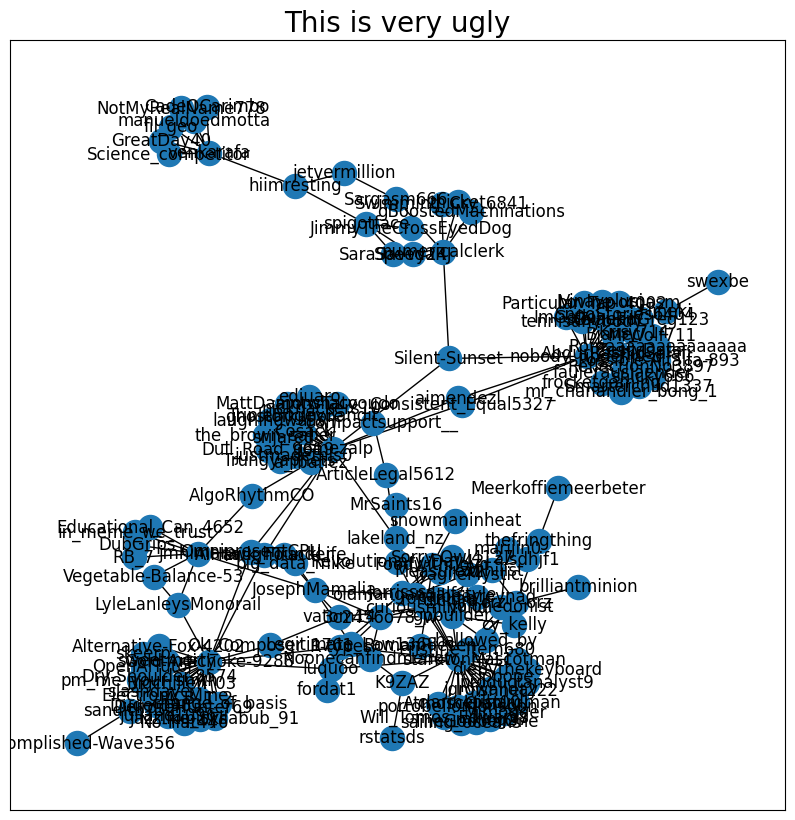

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx(GG, pos)
plt.title("This is very ugly", fontsize= 20)

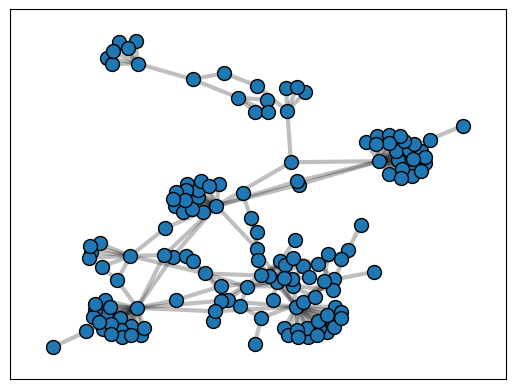

In [24]:
nx.draw_networkx_edges(GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(GG, pos, node_size=100).set_edgecolor('black')

In [25]:
node_attribute_df.to_csv('node_attribute.csv', index=False)
weighted_EL_df.to_csv('edge_commenting.csv', index=False)

# 2. User similarity networks
The goal of this section is to link users with similar activities. We will then visualize this network. The overall steps are:
- Load the dataframe.
- Construct a bipartite network and project on user side.
- Such projection results in a co-affiliation network.
- Visualize network.

In [26]:
ds_user_submission_df = pd.read_csv("./datascience-user-submission.csv")
ds_user_comment_df = pd.read_csv("./datascience-user-comment.csv")

In [27]:
# Concatenate the DataFrames
ds_user_combined_df = pd.concat([ds_user_submission_df[['author', 'subreddit']],
                                 ds_user_comment_df[['author', 'subreddit']]],
                                 ignore_index=True)

In [28]:
ds_user_combined_df = ds_user_combined_df[ds_user_combined_df['subreddit'] != 'datascience']
ds_user_combined_df

,author,subreddit
3,santiviquez,MachineLearning
4,santiviquez,MachineLearning
6,starktonny11,ProductManagement
7,starktonny11,BostonU
9,starktonny11,amex
...,...,...
1650,Novel_Frosting_1977,handyman
1651,SaraSavvy24,learnmachinelearning
1653,SaraSavvy24,learnmachinelearning
1654,SaraSavvy24,machinelearningmemes


In [29]:
from networkx.algorithms import bipartite

# Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(ds_user_combined_df['author'], bipartite=0)
B.add_nodes_from(ds_user_combined_df['subreddit'], bipartite=1)
# Add edges between users and subreddits
B.add_edges_from(ds_user_combined_df.itertuples(index=False))

# Project the bipartite graph onto the user nodes
users = ds_user_combined_df['author'].unique()
U_G = bipartite.weighted_projected_graph(B, users)

In [30]:
# Remove isolated nodes
U_GG = U_G.copy()
U_GG.remove_nodes_from(list(nx.isolates(U_GG)))

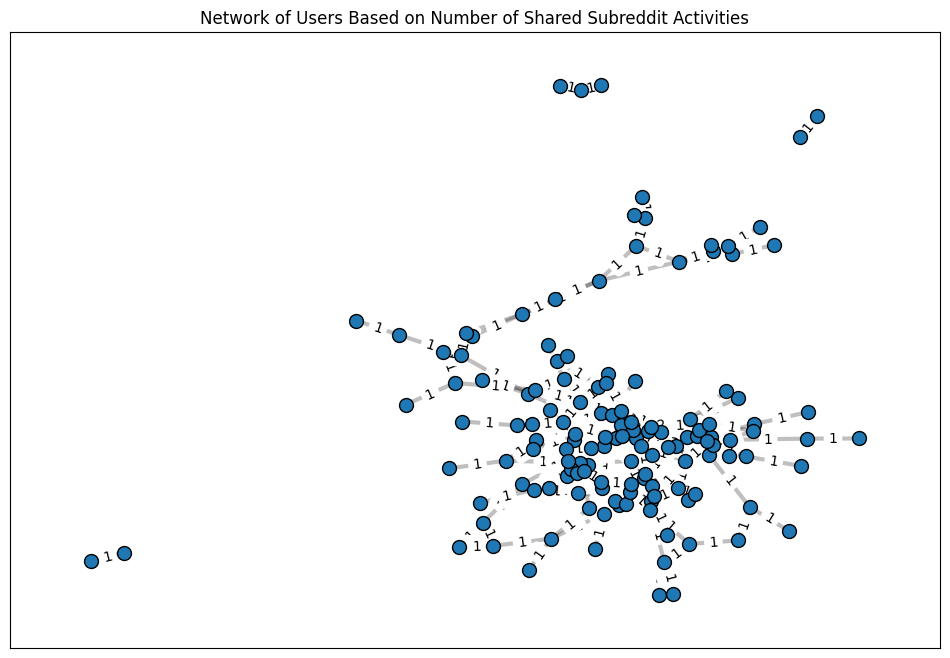

In [31]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(U_GG, weight = 'weight')  # Positioning of nodes
edges = U_GG.edges(data=True)
nx.draw_networkx_edges(U_GG, pos, alpha=0.25, width=3)
nx.draw_networkx_nodes(U_GG, pos, node_size=100).set_edgecolor('black')

nx.draw_networkx_edge_labels(U_GG, pos, edge_labels={(u, v): str(d["weight"]) for u, v, d in U_GG.edges(data=True)}, font_size=10)
plt.title("Network of Users Based on Number of Shared Subreddit Activities")
plt.show()

In [32]:
# Create a list to store the edges and their weights
edge_list = []
for u, v, data in U_G.edges(data=True):
    edge_list.append([u, v, data['weight']])

# Create a Pandas DataFrame from the edge list
user_graph_edgelist_df = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])
user_graph_edgelist_df


,Source,Target,Weight
0,santiviquez,LyleLanleysMonorail,2
1,santiviquez,Dull_Road_9619,1
2,santiviquez,AIHawk_Founder,1
3,santiviquez,Particular_Tap_4002,1
4,santiviquez,slashdave,1
...,...,...,...
332,Will_Tomos_Edwards,slashdave,1
333,slashdave,Dull_Road_9619,1
334,slashdave,srijared,1
335,slashdave,pm_me_your_smth,1


In [33]:
user_graph_edgelist_df.to_csv('edge_user_similarity.csv', index=False)

# 3. Subreddit networks

The goal of this section is to merge different dataframes of each subreddit, into a network.
We will then visualize this network.
The overall steps are:
- Load the dataframes.
- Make dictionaries {key: value} that contain each subreddit as keys, and the list of unique users as values.
- Generating an edgelist (weighted by number of shared users), then use it to generate a network object.
- Visualize network

### Read dataframe
We will use six files, each of the files has submission(=post) data of each subreddit dedicated to one programming language.

In [34]:
%cd '/content/drive/MyDrive/Tutorial_2'

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Correct the file paths based on where you uploaded files
files = {
    'DS': "./datascience-new-submission-for-subreddit-network.csv",
    'ML': "./MachineLearning-new-submission-for-subreddit-network.csv",
    'Data': "./datasets-new-submission-for-subreddit-network.csv",
    'Viz': "./dataisbeautiful-new-submission-for-subreddit-network.csv",
    'Py': "./learnpython-new-submission-for-subreddit-network.csv",
}

/content/drive/MyDrive/Tutorial_2


From the files, we can make a dictionary that contains keys as each subreddits, and values as unique users of each subreddits.

In [35]:
# Extract unique authors from each file
unique_authors = {file_name: pd.read_csv(file_path)['author'].unique().tolist() for file_name, file_path in files.items()}
unique_authors['DS'][:10]

['santiviquez',
 'jmhimara',
 'nobody_undefined',
 'gomezalp',
 'Waste_Necessary654',
 'starktonny11',
 'venkarafa',
 'ArticleLegal5612',
 'Gold-Artichoke-9288',
 'Careful_Engineer_700']

In [36]:
# Find the intersection of unique authors in 'R' and 'Python'
intersection = set(unique_authors['DS']).intersection(set(unique_authors['ML']))

# Print the intersection
print(intersection)


{'AutoModerator', 'yourmamaman', 'Starktony11'}


After we make that dictionary, we make multiple pairwise comparisons, and count the number of shared users to make an edgelist. For example, if a user A posted on both r/Python and r/rprogramming, we add 1 to the weight of the link between Python and R.

In [37]:
# Recreate the edge list dataframe
edge_list_data = []

for file_1 in unique_authors.keys():
    for file_2 in unique_authors.keys():
        if file_1 != file_2:
            # Calculate intersection of authors
            common_authors = set(unique_authors[file_1]).intersection(set(unique_authors[file_2]))
            if common_authors:
                edge_list_data.append([file_1, file_2, len(common_authors)])



In [38]:
# Convert the edge list data to a dataframe
edge_list_df = pd.DataFrame(edge_list_data, columns=['Source', 'Target', 'Weight'])
edge_list_df

,Source,Target,Weight
0,DS,ML,3
1,DS,Viz,1
2,ML,DS,3
3,ML,Data,1
4,Data,ML,1
5,Data,Viz,1
6,Viz,DS,1
7,Viz,Data,1


Let's visualize it in a simple way.

In [39]:
G = nx.from_pandas_edgelist(edge_list_df, 'Source', 'Target', edge_attr='Weight', create_using=nx.Graph())

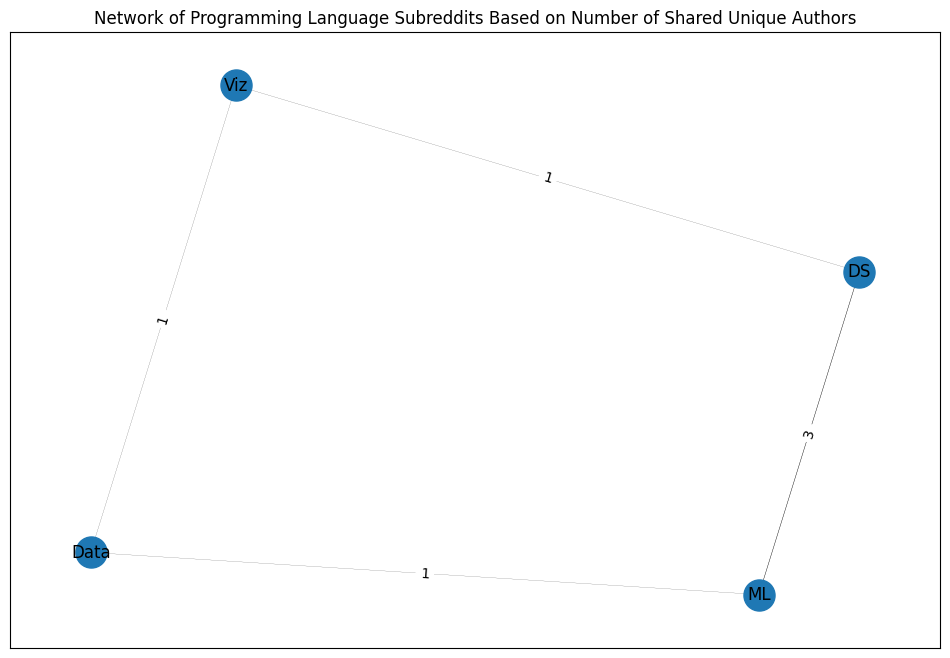

In [40]:
# Visualization with edge weights displayed
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, weight = 'Weight')  # Positioning of nodes
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edata['Weight'] * 0.1 for _, _, edata in edges])
nx.draw_networkx_labels(G, pos, font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): str(d["Weight"]) for u, v, d in G.edges(data=True)}, font_size=10)
plt.title("Network of Programming Language Subreddits Based on Number of Shared Unique Authors")
plt.show()

# On your own
With csv files that you scraped with Reddit Scraper, make 3 types of networks (user interaction, user similarity, subreddit similarity) and visualize them.